# Аналитика в Яндекс.Афише

Задача - помочь маркетологам оптимизировать маркетинговые затраты. В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период, статистика рекламных расходов.

**Необходимо изучить:**
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент,
- когда клиент окупается.

## План исследования: <a id="step0"></a>
[**Шаг 1. Загрузка файлов с данными и изучение информации**](#step1)

[**Шаг 2. Подготовка данных**](#step2)

[**Шаг 3. Построение отчётов и подсчет метрик**](#step3)

**3.1 Продукт**
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

**3.2 Продажи**
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

**3.3 Маркетинг**
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

[**Шаг 4. Рекомендации маркетологам**](#step4)

## Исследование:
## Шаг 1. Загрузка файлов с данными и изучение информации <a id="step1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [2]:
visits = pd.read_csv('/Users/maxim/Documents/Edu/DA/Yandex/Datasets/07_yandex_afisha/visits_log.csv')
orders = pd.read_csv('/Users/maxim/Documents/Edu/DA/Yandex/Datasets/07_yandex_afisha/orders_log.csv')
costs = pd.read_csv('/Users/maxim/Documents/Edu/DA/Yandex/Datasets/07_yandex_afisha/costs.csv')

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

In [7]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

### Вывод
Данные представлены в 3 датасетах, пропусков нет. **Необходимо** привести временные данные к типу datetime64, переименовать столбцы.

## Шаг 2. Подготовка данных <a id="step2"></a>
[*Наверх к плану*](#step0)

Переименуем столбцы:

In [9]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['order_ts', 'revenue', 'uid']
costs.columns = ['source_id', 'date', 'costs']
print(visits.columns.to_list()) #проверяем
print(orders.columns.to_list())
print(costs.columns.to_list())

['device', 'end_ts', 'source_id', 'start_ts', 'uid']
['order_ts', 'revenue', 'uid']
['source_id', 'date', 'costs']


Приводим данные, содержащие временные отметки, к типу datetime64:

In [10]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['order_ts'] = pd.to_datetime(orders['order_ts'])
costs['date'] = pd.to_datetime(costs['date'])

#проверяем работу
for i in visits, orders, costs:
    print(i.info())
    print('-----------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_ts    50415 non-null datetime64[ns]
revenue     50415 non-null float64
uid         50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), 

Проверяем наличие дубликатов:

In [11]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Произвели обработку данных, теперь они готовы для анализа.

## Шаг 3. Построение отчётов и подсчет метрик <a id="step3"></a>
[*Наверх к плану*](#step0)

### 3.1 Продукт
**Количество пользователей в день, неделю, месяц:**

In [12]:
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week 
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
#выделяем временные отметки в отдельные столбцы.
#Год для данного датасета не нужен, но выделим его для возможности исследования датасетов длительностью больше года.

dau_total = visits.groupby(['year', 'date']).agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()

print('Среднее количество пользователей в день: {:.0f} человек.'.format(dau_total[0]))
print('Среднее количество пользователей в неделю: {:.0f} человек.'.format(wau_total[0]))
print('Среднее количество пользователей в месяц: {:.0f} человек.'.format(mau_total[0]))

Среднее количество пользователей в день: 908 человек.
Среднее количество пользователей в неделю: 5716 человек.
Среднее количество пользователей в месяц: 23228 человек.


**Количество сессий в день:**

In [13]:
session_cnt = visits.groupby('date')['uid'].count().mean()
print('Среднее количество сессий в день: {:.0f}'.format(session_cnt)) 

Среднее количество сессий в день: 987


In [14]:
sessions_unique_user_cnt = visits.groupby('date')['uid'].nunique().mean()
print('Среднее количество сессий уникальных посетителей в день: {:.0f}'.format(sessions_unique_user_cnt))

Среднее количество сессий уникальных посетителей в день: 908


**Длительность одной сессии (ASL):**

In [15]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds #создаем столбец для каждой сессии
print('Результат: {:.1f} сек. или {:.1f} мин.'.format(visits['session_duration_sec'].mean(),\
                                                      (visits['session_duration_sec'].mean())/60)) 

Результат: 643.5 сек. или 10.7 мин.


Довольно большое среднее значение. Посмотрим на значение и проверим распределение:

In [16]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

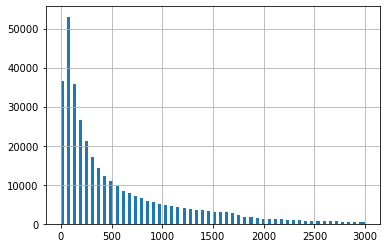

In [17]:
visits['session_duration_sec'].hist(bins=100, range=(0,3000));

При нормальном распределении, было бы уместно высчитывать среднее или медианное значение. Но в данном случае распределение не относится к нормальным, поэтому, рассчитаем моду и примем её значение за ASL:

In [18]:
session_duration = visits['session_duration_sec'].mode()
print('Средняя длительность одной сессии: {:.0f} сек.'.format(session_duration[0]))

Средняя длительность одной сессии: 60 сек.


**Возвращаемость клиентов (Retention rate)** \
Сформируем когорту периодом в 1 месяц с учетом специфики сервиса. На культурные мероприятия вряд ли ходят раз в неделю.

In [19]:
first_activity_date = visits.groupby('uid')['start_ts'].min() #записываем дату первого посещения в Series
first_activity_date.name = 'first_activity_date' #меняем имя в Series
visits = visits.join(first_activity_date, on='uid') #джойним результат к датасету
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-27 14:06:00


In [20]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]') #получаем значение месяца
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

#получим lifetime для пользователей в рамках когорты
visits['cohort_lifetime'] = ((visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1,'M'))
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

#группируем данные по когорте и lifetime и считаем количество активных пользователей на период жизни когорты:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю:

In [21]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_activity_month', 'uid']]
initial_users_count

,first_activity_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [22]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) #переименуем стобец для дальнейшего объединения
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [23]:
#получим Retention Rate и построим сводную таблицу
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(
            index='first_activity_month', 
            columns='cohort_lifetime', 
            values='retention',
            aggfunc='sum').round(3)

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.079,0.054,0.061,0.069,0.071,0.061,0.058,0.052,0.051,0.041,0.045
2017-07-01,1.0,0.056,0.051,0.056,0.058,0.048,0.045,0.046,0.039,0.029,0.027,NaN
2017-08-01,1.0,0.077,0.063,0.063,0.050,0.044,0.036,0.039,0.028,0.026,NaN,NaN
2017-09-01,1.0,0.085,0.069,0.051,0.039,0.038,0.036,0.024,0.023,NaN,NaN,NaN
2017-10-01,1.0,0.079,0.052,0.039,0.034,0.032,0.021,0.020,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078,0.044,0.039,0.034,0.023,0.022,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.056,0.038,0.031,0.020,0.019,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.060,0.039,0.025,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057,0.025,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим нулевой столбец, так как показатели в следующих месяцах сильно контрастируют с максимальным значением, и теплова карта не отобразит различия. После этого отрисуем карту:

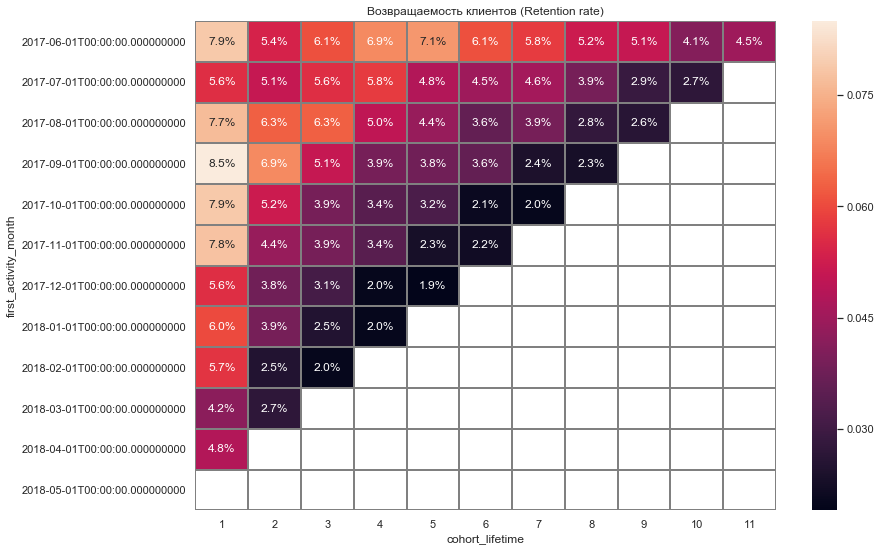

In [24]:
retention_pivot = retention_pivot.drop(columns=[0])

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Возвращаемость клиентов (Retention rate)')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Построим тепловую карту:

Retention Rate резко убывает с первого месяца по всем когортам и в последующих месяцах держится на примерно таком же уровне 5-7%. Повторных посещений крайне мало. Дальнейшее падение этого значения в каждой когорте отмечается в марте - до 2%. Это может быть отчасти связано с сезонностью мероприятий, отсутствием интересных предложений у сервиса, снижением затрат на маркетинг или другими причинами.

Отдельно посмотрим на **распределение клиентов, пользующихся ресурсом с компьютеров или смартфонов/планшетов**, в разбивке по дням, неделям и месяцам:

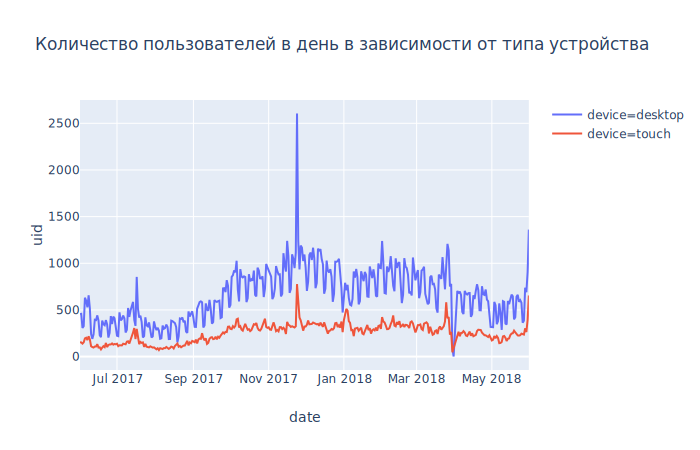

In [25]:
daily_visits_device = visits.groupby(['device', 'date'])['uid'].nunique().reset_index()

fig_daily_visits = px.line(
    daily_visits_device, 
    x='date', 
    y='uid', 
    color='device', 
    title='Количество пользователей в день в зависимости от типа устройства')
fig_daily_visits.show("svg")

In [26]:
costs.query('"2017-11-21" < date < "2017-11-27"').groupby('date')['costs'].sum() #исследуем причину пика 24 ноября 2017г

date
2017-11-22    1145.03
2017-11-23    1300.34
2017-11-24    3458.86
2017-11-25    1747.36
2017-11-26    1047.25
Name: costs, dtype: float64

- Пользователи Яндекс.Афиши предпочитают пользоваться сервисом с компьютеров. Доля таких пользователей в 2-3 раза выше по сравнению с мобильными устройствами на всём временном промежутке исследуемых данных. При масштабировании графиков видно, что пики посещаемости с десктопов приходятся на будние дни. Это связано с типичной активностью для такой платформы, а также с тем, что некоторые пользователи заходят на ресурс в дневное рабочее время с компьютеров;
- Рост активности пользователей наблюдается в сезон культурных мероприятий - холодное время года, период с сентября по март;
- Пик посещений ресурса 24 ноября 2017г. объясняется дополнительными затратами на маркетинг: бюджет в этот день в 2-3 раза превышает затраченные суммы в соседние даты.

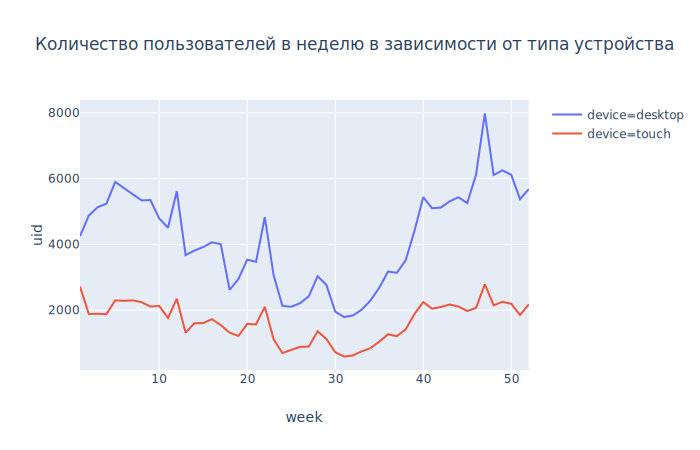

In [27]:
weekly_visits_device = visits.groupby(['device', 'week'])['uid'].nunique().reset_index()

fig_weekly_visits = px.line(
    weekly_visits_device, 
    x='week', 
    y='uid', 
    color='device', 
    title='Количество пользователей в неделю в зависимости от типа устройства')
fig_weekly_visits.show("svg")

Данные расположились в хронологическом порядке номеров недель, начиная с начала года, и так же отражают сезонность культурных и массовых мероприятий, в том числе сезон выхода кинопремьер, на которых специализируется ресерс. Пики приходятся на время увеличения затрат на маркетинг.

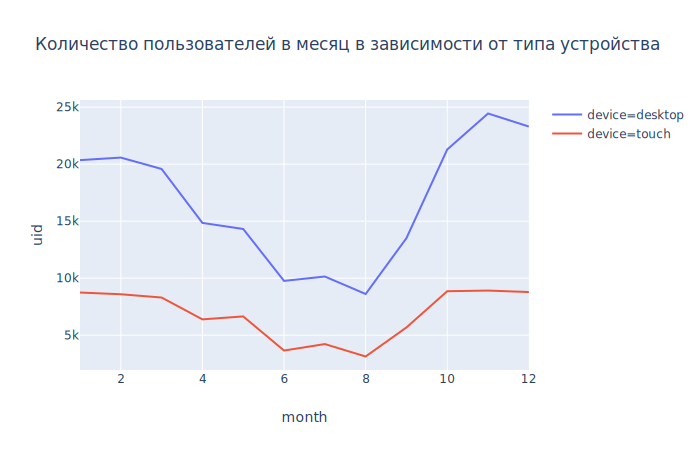

In [28]:
monthly_visits_device = visits.groupby(['device', 'month'])['uid'].nunique().reset_index()

fig_monthly_visits = px.line(
    monthly_visits_device, 
    x='month', 
    y='uid', 
    color='device', 
    title='Количество пользователей в месяц в зависимости от типа устройства')
fig_monthly_visits.show("svg")

График по месяцам нагляднее отображает разницу между платформами и сезонность пользования ресурсом, подтверждая выводы, сделанные под графиками выше.

### 3.2 Продажи
**Время, когда пользователи начинают совершать покупки:**

In [29]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,session_duration_sec,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [30]:
orders.head()

,order_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [31]:
#соберем таблицу с отметкой первого посещения и первой покупки:
first_visit = visits.groupby('uid').agg({'start_ts':'min'}).rename(columns={'start_ts':'first_activity_date'}).reset_index()
first_order = orders.groupby('uid').agg({'order_ts':'min'}).rename(columns={'order_ts':'first_order_date'}).reset_index()
time_to_order = first_visit.merge(first_order, on='uid', how='inner')
time_to_order.head()

,uid,first_activity_date,first_order_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


In [32]:
#считаем время первой покупки
time_to_order['time_to_order'] = (time_to_order['first_order_date'] - time_to_order['first_activity_date']).dt.seconds / 60

Посмотрим на значения и распределение данных, чтобы определиться с подсчетом среднего значения:

In [33]:
time_to_order['time_to_order'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: time_to_order, dtype: float64

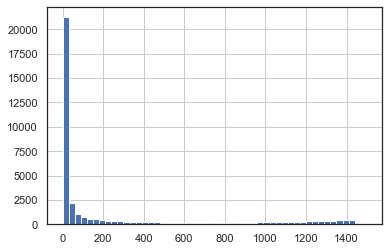

In [34]:
time_to_order['time_to_order'].hist(bins=50, range=(0,1500));

Распределение не является нормальным. Воспользуемся модой:

In [35]:
time_to_order_mode = time_to_order['time_to_order'].mode()
print('Время совершения первой покупки: {:.0f} мин.'.format(time_to_order_mode[0]))

Время совершения первой покупки: 1 мин.


Большинство покупателей (показатель "мода") совершают покупку спустя минуту после посещения сайта. Медианное значение - 16 минут. 25% клиентам требуется от 4 часов и более на совершение целевого действия.

**Количество покупок за период:**

In [36]:
#Выделим временные отметки в отдельные столбцы для подсчета:
orders['date'] = orders['order_ts'].dt.date
orders['week'] = orders['order_ts'].dt.week
orders['month'] = orders['order_ts'].dt.month

#Группируем по периоду и считаем средние значения
orders_day = orders.groupby('date')['uid'].count().mean()
orders_week = orders.groupby('week')['uid'].count().mean()
orders_month = orders.groupby('month')['uid'].count().mean()

print('Среднее количество покупок в день: {:.0f} шт.'.format(orders_day))
print('Среднее количество покупок в неделю: {:.0f} шт.'.format(orders_week))
print('Среднее количество покупок в месяц: {:.0f} шт.'.format(orders_month))

Среднее количество покупок в день: 139 шт.
Среднее количество покупок в неделю: 970 шт.
Среднее количество покупок в месяц: 4201 шт.


**Средний чек:**

In [37]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

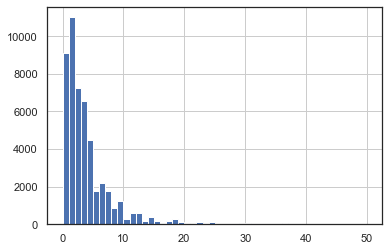

In [38]:
orders['revenue'].hist(bins=50, range=(0,50));

In [39]:
orders['revenue'].mode()[0]

1.83

Для такого распределения среднее значение найдем с помощью моды или медианы. В выборке присутствуют выбросы. Значение моды для среднего чека: 1.83, медианы: 2.5.

**LTV клиента:**

In [40]:
orders.head()

,order_ts,revenue,uid,date,week,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6


In [41]:
orders['order_month'] = orders['order_ts'].astype('datetime64[M]') #выделяем месяц покупки

In [42]:
#получим месяц первой покупки каждого пользователя 
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [43]:
#считаем количество новых покупателей за каждый месяц:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [44]:
#добавляем месяц первой покупки
orders_new = pd.merge(orders, first_orders, on='uid') 
orders_new.head()

,order_ts,revenue,uid,date,week,month,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017-06-01,2017-06-01


In [45]:
#группируем таблицу по месяцу первой покупки и месяцу каждого заказа, складываем выручку, чтобы получить прибыль от когорты
cohorts = orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [46]:
#добавим в таблицу cohorts количество покупателей:
result = pd.merge(cohorts, cohort_sizes, on='first_order_month')
result.head()

,first_order_month,order_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


Для подсчета LTV нужно знать валовую прибыль. Этот показатель равен произведению выручки и маржинальности. Значение маржмнальности не заявлено в условии - примем единицу. Оставим формулу, если маржинальность будет изменена.

In [47]:
margin_rate = 1 
result['gp'] = result['revenue'] * margin_rate
result['age'] = ((result['order_month'] - result['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int') #возраст когорты
result.head()

,first_order_month,order_month,revenue,n_buyers,gp,age
0,2017-06-01,2017-06-01,9557.49,2023,9557.49,0
1,2017-06-01,2017-07-01,981.82,2023,981.82,1
2,2017-06-01,2017-08-01,885.34,2023,885.34,2
3,2017-06-01,2017-09-01,1931.30,2023,1931.30,3
4,2017-06-01,2017-10-01,2068.58,2023,2068.58,4


In [48]:
result['ltv'] = result['gp'] / result['n_buyers'] #считаем lTV

In [49]:
report_ltv = result.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(1)
    
report_ltv.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.7,0.5,0.4,1,1,0.7,1,0.6,0.6,0.6,0.6,0.3
2017-07-01,6.0,0.3,0.6,0.4,0.2,0.2,0.1,0.1,0.2,0.1,0.2,
2017-08-01,5.3,0.5,0.5,0.4,0.5,0.3,0.2,0.4,0.3,0.2,,
2017-09-01,5.6,1.1,0.5,4,0.4,0.6,0.7,0.2,0.2,,,
2017-10-01,5.0,0.5,0.2,0.2,0.2,0.1,0.1,0.1,,,,
2017-11-01,5.2,0.4,0.2,0.3,0.1,0.1,0.1,,,,,
2017-12-01,4.7,0.3,0.9,1.1,0.3,0.3,,,,,,
2018-01-01,4.1,0.3,0.3,0.1,0.1,,,,,,,
2018-02-01,4.2,0.3,0.1,0.1,,,,,,,,


Последовательно сложим LTV для каждоый когорты и изобразим результат в виде тепловой карты:

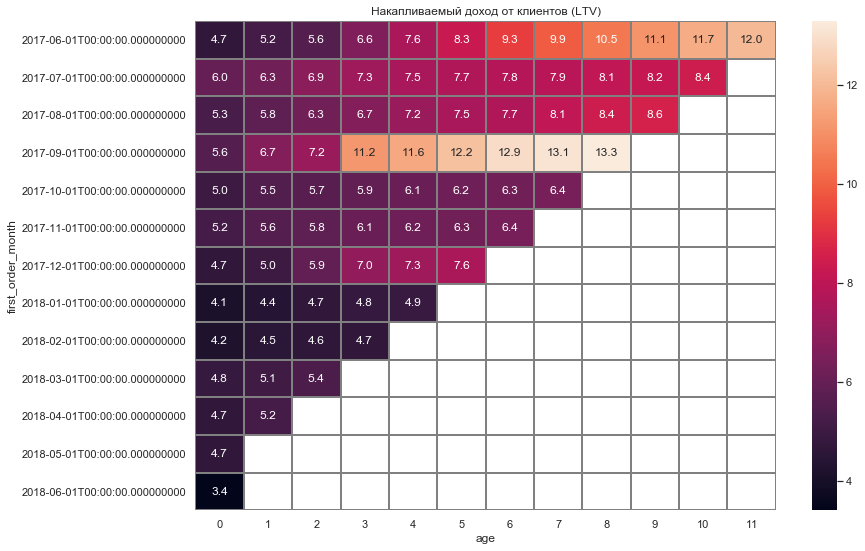

In [50]:
report_ltv_cumsum = report_ltv.cumsum(axis=1)

sns.set(style='whitegrid')
plt.figure(figsize=(13, 9))
plt.title('Накапливаемый доход от клиентов (LTV)')
sns.heatmap(report_ltv_cumsum, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

- В среднем каждый покупатель из первой когорты принес выручки на 12 единиц за один год «жизни»;
- Сравнивая LTV между 7 первыми когортами (берем равный промежуток времени для каждой из когорт - 6 месяцев), результаты не сильно различаются - промежуток 6.2-8.3. В этом сравнении выделяется когорта сентября 2017 года с резким приростом LTV в декабре 2018 года (предновогодние мероприятия) и общим результатом 12.2 единицы.

### 3.3 Маркетинг
**Затраченные деньги: всего / на каждый источник / по времени**

In [51]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


##### Общие затраты:

In [52]:
monthly_costs = costs.costs.sum()
monthly_costs

329131.62

##### Затраты на каждый источник:

In [53]:
source_costs = costs.groupby('source_id').costs.sum().round().astype('int').sort_values(ascending=False)
source_costs

source_id
3     141322
4      61074
5      51757
2      42806
1      20833
10      5822
9       5517
Name: costs, dtype: int64

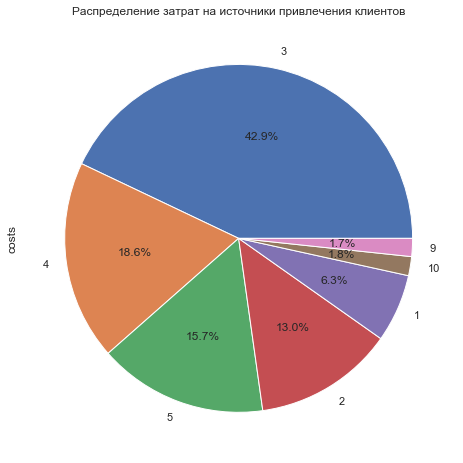

In [54]:
plt.figure(figsize=(8, 8))
plt.title('Распределение затрат на источники привлечения клиентов')
source_costs.plot(kind='pie', autopct='%1.1f%%');

В лидерах с большим отрывом по затратам - источник №3, на который приходится 42.9% бюджета. Далее следуют источники №4 и №5.

##### Затраты по времени:

In [55]:
costs['month'] = costs['date'].dt.month  #выделяем месяц
costs_per_month = costs.groupby('month').costs.sum().round().astype('int')
costs_per_month

month
1     33519
2     32723
3     30415
4     22289
5     22224
6     18015
7     18241
8     14791
9     24369
10    36323
11    37908
12    38315
Name: costs, dtype: int64

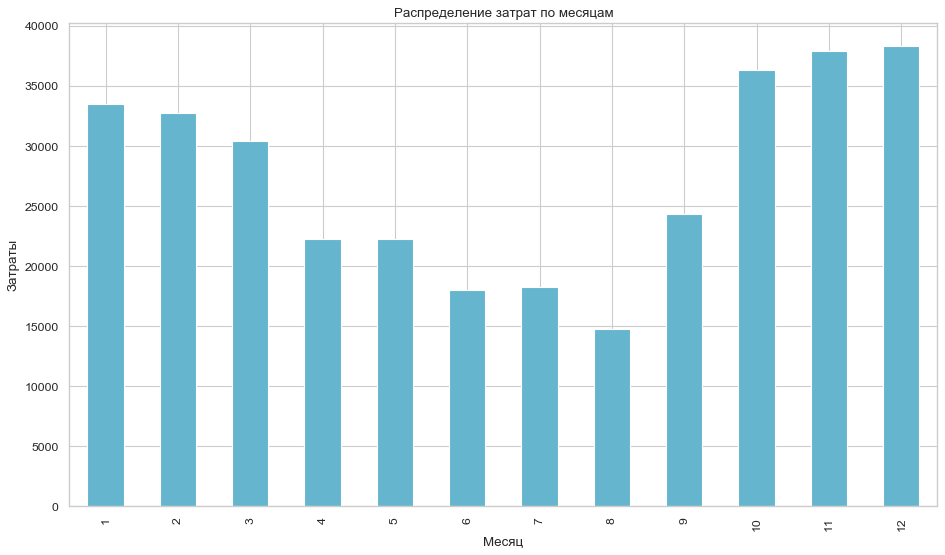

In [56]:
plt.figure(figsize=(14,8), dpi= 80)
costs_per_month.plot(kind='bar', color='c')
plt.title('Распределение затрат по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Затраты');

С апреля по сентябрь ежемесячные суммы вложений в привлечение клиентов ниже, чем в другие месяцы. Это может быть связано с сезонностью, так как в теплые месяцы проводится значительно меньше культурных мероприятий, многие клиенты находятся в отпусках. Наименьшие затраты наблюдаются в июне, июле и августе. Наибольшие затраты сервис проводит в период с октября по март.

**Стоимость привлечения одного покупателя из каждого источника (CAC):**

In [57]:
visits_per_source = visits.query('start_ts == first_activity_date') #фильтруем повторные заказы
buyers_per_source = (
    (orders.merge(visits_per_source, on='uid', how='inner')) #объединяем таблицы по uid
    .groupby('source_id')
    .agg({'uid':'nunique'}) #считаем уникальных покупателей в группировке по источнику
    .rename(columns={'uid':'n_buyers'})
    .reset_index()
)
buyers_per_source

,source_id,n_buyers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [58]:
source_costs = source_costs.reset_index()
cac = source_costs.join(buyers_per_source.set_index('source_id'), on='source_id') 
cac.sort_values('source_id').reset_index(drop=True)

,source_id,costs,n_buyers
0,1,20833,2899
1,2,42806,3506
2,3,141322,10473
3,4,61074,10296
4,5,51757,6931
5,9,5517,1088
6,10,5822,1329


In [59]:
cac['cac'] = (cac['costs'] / cac['n_buyers']).round(2)
cac.sort_values('cac')

,source_id,costs,n_buyers,cac
5,10,5822,1329,4.38
6,9,5517,1088,5.07
1,4,61074,10296,5.93
4,1,20833,2899,7.19
2,5,51757,6931,7.47
3,2,42806,3506,12.21
0,3,141322,10473,13.49


Самая низкая стоимость привлечения клиентов, совершающих заказы, у источников №4,9,10. Самая высокая CAC у источника №3, откуда приходит наибольшее количество покупателей.

**Окупаемость расходов (ROI)**\
В нашем случае мы имеем дело с расходами только на маркетинг. Поэтому, будем рассчитывать ROI по формуле ROMI: отношение LTV к CAC.

In [60]:
#добавим первый источник трафика
first_activity_source = visits.groupby('uid')['source_id'].first() 
first_activity_source.name = 'first_activity_source'
orders_roi = orders_new.join(first_activity_source, on='uid')
orders_roi.head(10)

,order_ts,revenue,uid,date,week,month,order_month,first_order_month,first_activity_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22,6,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22,6,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22,6,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22,6,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22,6,2017-06-01,2017-06-01,3
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,22,6,2017-06-01,2017-06-01,3
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,22,6,2017-06-01,2017-06-01,5
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-05,23,6,2017-06-01,2017-06-01,5
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,22,6,2017-06-01,2017-06-01,1
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-02,22,6,2017-06-01,2017-06-01,1


In [61]:
orders_roi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 9 columns):
order_ts                 50415 non-null datetime64[ns]
revenue                  50415 non-null float64
uid                      50415 non-null uint64
date                     50415 non-null object
week                     50415 non-null int64
month                    50415 non-null int64
order_month              50415 non-null datetime64[ns]
first_order_month        50415 non-null datetime64[ns]
first_activity_source    50415 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(3), object(1), uint64(1)
memory usage: 3.8+ MB


Ранее при подсчете LTV мы выделяли когорты по месяцу первой покупки. Сейчас дополнительно сгруппируем данные по первому источнику трафика и найдем количество покупателей, выручку в каждой когорте и в каждом источнике:

In [62]:
result_roi = (
    orders_roi
    .groupby(['first_order_month', 'first_activity_source'])
    .agg({'uid': 'nunique', 'revenue': 'sum'})
    .rename(columns={'uid': 'n_buyers'})
    .reset_index()
)
result_roi.head(10)

,first_order_month,first_activity_source,n_buyers,revenue
0,2017-06-01,1,203,7022.25
1,2017-06-01,2,271,6278.12
2,2017-06-01,3,574,3049.43
3,2017-06-01,4,417,2926.40
4,2017-06-01,5,368,4091.29
5,2017-06-01,9,103,457.90
6,2017-06-01,10,87,206.30
7,2017-07-01,1,211,3651.29
8,2017-07-01,2,257,2700.35
9,2017-07-01,3,443,2582.29


In [63]:
#по аналогии добавляем расчет валовой прибыли, которая в данном случае дублирует выручку
result_roi['gp'] = result_roi['revenue'] * margin_rate  
result_roi.head()

,first_order_month,first_activity_source,n_buyers,revenue,gp
0,2017-06-01,1,203,7022.25,7022.25
1,2017-06-01,2,271,6278.12,6278.12
2,2017-06-01,3,574,3049.43,3049.43
3,2017-06-01,4,417,2926.40,2926.40
4,2017-06-01,5,368,4091.29,4091.29


In [64]:
result_roi['ltv'] = result_roi['gp'] / result_roi['n_buyers'] #считаем lTV
result_roi['ltv'] = result_roi['ltv'].round(2)
result_roi.head()

,first_order_month,first_activity_source,n_buyers,revenue,gp,ltv
0,2017-06-01,1,203,7022.25,7022.25,34.59
1,2017-06-01,2,271,6278.12,6278.12,23.17
2,2017-06-01,3,574,3049.43,3049.43,5.31
3,2017-06-01,4,417,2926.40,2926.40,7.02
4,2017-06-01,5,368,4091.29,4091.29,11.12


In [65]:
costs['first_source_month'] = costs['date'].astype('datetime64[M]') #выделяем месяц первого источника

#считаем затраты в группировке по месяцу первого источника и каждому источнику отдельно
costs_grouped = costs.groupby(['first_source_month', 'source_id'])['costs'].sum().reset_index() 
costs_grouped.head(10)

,first_source_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
5,2017-06-01,9,285.22
6,2017-06-01,10,314.22
7,2017-07-01,1,1072.88
8,2017-07-01,2,2333.11
9,2017-07-01,3,7674.37


In [66]:
report = pd.merge(result_roi, costs_grouped, left_on=['first_order_month', 'first_activity_source'],\
                 right_on=['first_source_month', 'source_id']) #объединяем таблицы по двум полям
report.head(10)

,first_order_month,first_activity_source,n_buyers,revenue,gp,ltv,first_source_month,source_id,costs
0,2017-06-01,1,203,7022.25,7022.25,34.59,2017-06-01,1,1125.61
1,2017-06-01,2,271,6278.12,6278.12,23.17,2017-06-01,2,2427.38
2,2017-06-01,3,574,3049.43,3049.43,5.31,2017-06-01,3,7731.65
3,2017-06-01,4,417,2926.40,2926.40,7.02,2017-06-01,4,3514.80
4,2017-06-01,5,368,4091.29,4091.29,11.12,2017-06-01,5,2616.12
5,2017-06-01,9,103,457.90,457.90,4.45,2017-06-01,9,285.22
6,2017-06-01,10,87,206.30,206.30,2.37,2017-06-01,10,314.22
7,2017-07-01,1,211,3651.29,3651.29,17.30,2017-07-01,1,1072.88
8,2017-07-01,2,257,2700.35,2700.35,10.51,2017-07-01,2,2333.11
9,2017-07-01,3,443,2582.29,2582.29,5.83,2017-07-01,3,7674.37


In [67]:
#добавляем в отчет расчет CAC и ROI
report['cac'] = (report['costs'] / report['n_buyers']).round(2) 
report['roi'] = report['ltv'] / report['cac']
report.head(10)

,first_order_month,first_activity_source,n_buyers,revenue,gp,ltv,first_source_month,source_id,costs,cac,roi
0,2017-06-01,1,203,7022.25,7022.25,34.59,2017-06-01,1,1125.61,5.54,6.243682
1,2017-06-01,2,271,6278.12,6278.12,23.17,2017-06-01,2,2427.38,8.96,2.585938
2,2017-06-01,3,574,3049.43,3049.43,5.31,2017-06-01,3,7731.65,13.47,0.394209
3,2017-06-01,4,417,2926.40,2926.40,7.02,2017-06-01,4,3514.80,8.43,0.832740
4,2017-06-01,5,368,4091.29,4091.29,11.12,2017-06-01,5,2616.12,7.11,1.563994
5,2017-06-01,9,103,457.90,457.90,4.45,2017-06-01,9,285.22,2.77,1.606498
6,2017-06-01,10,87,206.30,206.30,2.37,2017-06-01,10,314.22,3.61,0.656510
7,2017-07-01,1,211,3651.29,3651.29,17.30,2017-07-01,1,1072.88,5.08,3.405512
8,2017-07-01,2,257,2700.35,2700.35,10.51,2017-07-01,2,2333.11,9.08,1.157489
9,2017-07-01,3,443,2582.29,2582.29,5.83,2017-07-01,3,7674.37,17.32,0.336605


In [68]:
#строим сводную таблицу по источникам трафика в колонках
roi_pivot = report.pivot_table(
            index='first_order_month',
            columns='first_activity_source',
            values='roi',
            aggfunc='mean').round(2)
roi_pivot

first_activity_source,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,6.24,2.59,0.39,0.83,1.56,1.61,0.66
2017-07-01,3.41,1.16,0.34,1.09,0.86,2.03,0.47
2017-08-01,1.35,0.72,0.30,0.76,1.60,4.20,0.86
2017-09-01,2.98,6.34,0.35,0.72,0.85,1.27,0.43
2017-10-01,1.55,1.20,0.33,0.90,1.01,1.42,0.85
2017-11-01,1.40,0.87,0.36,1.34,0.52,1.37,0.68
2017-12-01,1.07,3.01,0.33,0.76,0.69,1.16,0.45
2018-01-01,1.33,0.47,0.24,0.69,0.65,0.77,0.44
2018-02-01,1.07,0.43,0.29,0.79,0.62,0.85,0.72


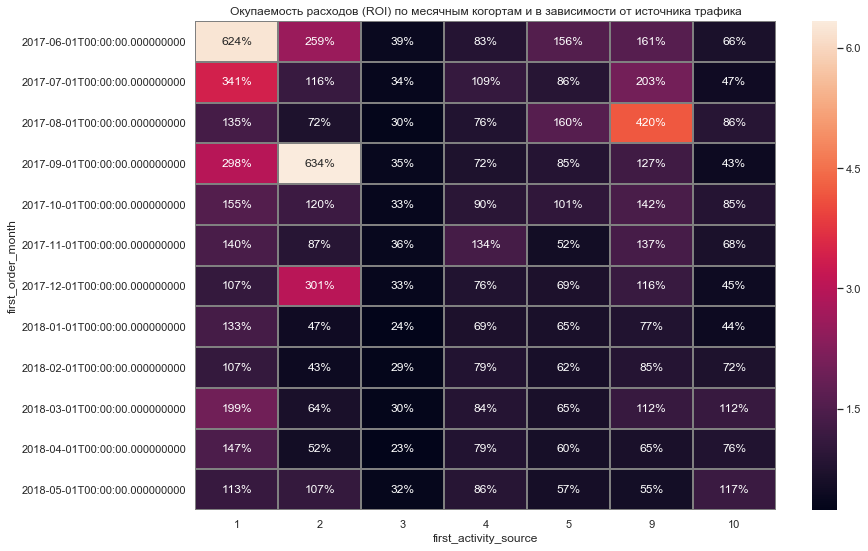

In [69]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Окупаемость расходов (ROI) по месячным когортам и в зависимости от источника трафика')
sns.heatmap(roi_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray');

Сразу посчитаем окупаемость расходов за весь период по каждому источнику:

In [70]:
for column in roi_pivot:
    print('№', column,' {:.0%}'.format((roi_pivot[column].mean()))) #проходим по каждому столбцу циклом

№ 1  208%
№ 2  158%
№ 3  31%
№ 4  86%
№ 5  85%
№ 9  142%
№ 10  72%


С окупаемостью расходов в разбивке по источнику трафика не всё в порядке:
- Источник №1 - единственный, который показывает двукратную окупаемость, а также остается в плюсе в каждой из 12 когорт;
- Источники №2 и №9 - окупаются в 6 и 8 когортах из 12 соответственно, демонстрируя при этом общую окупаемость за весь период;
- Источники №4, 5 и 10 - окупаются в 2-3 когортах и не дотягивают до общего плюса;
- Источник №3 показывает самые плохие результаты. В среднем ROI находится на отметке в 31%.

## Шаг 4. Рекомендации маркетологам <a id="step4"></a>
[*Наверх к плану*](#step0)

- У ресурса наблюдается крайне низкая возвращаемость клиентов (Retention rate) сразу на следующий месяц после первого использования и не поднимается выше 2-7% в дальнейшем. \
Необходимо обратить внимание на удержание клиентов: сбор отзывов, их анализ, внедрение акций/скидок на повторные заказы, расширение ассортимента предложения и т.д. Маркетологам рекомендуется поработать в этом направлении;
- Изучить мобильную версию / моб. приложение по критериям UI/UX, акцентировать продвижение этих платформ. Я бы сказал, что «не дело», когда десктопная версия опережает «тач» в 3 раза. Смартфон всегда при пользователе, это нужно использовать (скидка при заказе через приложение, пуш-уведомления и прочее). 
- Сезонность: изучить предпочтения клиентов в низкий сезон и добавить в ассортимент эти мероприятия/события/варианты отдыха/развлечения/фестивали. В летнее время люди не перестают тратить деньги, у них меняются предпочтения и иногда локация;
- Перераспределение расходов на рекламу между источниками. Обратить внимание на высокорезультативные источники №1, 2 и 9.